In [1]:
import os

import matplotlib.pyplot as plt
import xarray as xr

from src import data_catalog
from src import tseries_mod
from src import esmlab_wrap
from src.config import grid_dir, nino_obs_dir
from src.utils import repl_coord, smooth, da_normalize, da_w_lags, regression_slope
from src.utils_noaa_psd import psd_read_file
from src.utils_plot import plot_1var

In [2]:
data_catalog.set_catalog('cesm_land')

active catalog: cesm_land


In [3]:
time_slice = slice('1901-01-01', '2015-01-01')

In [4]:
varnames = {'lnd': ['NEE', 'GPP', 'NPP', 'AR', 'TOTVEGC', 'HR', 'COL_FIRE_CLOSS', 'TOTSOMC', 'TSA', 'RAIN', 'TSOI_10CM', 'SOILLIQ']}

ds_dict = {}
for component in varnames:
    ds_dict[component] = {}

for experiment in ['GSWP-CLM4', 'GSWP-CLM5']:
    for component in varnames:
        ds = tseries_mod.tseries_get_vars(varnames[component], component, experiment)
        ds_dict[component][experiment] = ds.sel(time=time_slice)

legend_dict = {'GSWP-CLM4': 'GSWP, CLM4',
               'GSWP-CLM5': 'GSWP, CLM5',
              }

In [5]:
def lnd_depth_avg(dz, zlim, da):
    vert_dim = da.dims[1]
    vert_dim_len = da.sizes[vert_dim]

    # restrict dz to layers of da
    dz_vert_dim = dz.dims[0]
    dz_for_da = dz.isel({dz_vert_dim: slice(0, vert_dim_len)}).rename({dz_vert_dim: vert_dim})

    # construct layer bounds
    layer_bot = dz_for_da.cumsum(dim=vert_dim)
    layer_top = layer_bot.shift({vert_dim: 1}, fill_value=0.0)

    # compute weights for averaging
    frac = (zlim - layer_top) / (layer_bot - layer_top)
    weight = xr.where(frac > 1.0, 1.0, xr.where(frac < 0.0, 0.0, frac)) * dz_for_da
    weight = weight / weight.sum(dim=vert_dim)

    # add vertical coordinate to da
    da = da.assign_coords({vert_dim: dz_for_da[vert_dim]})
    da_out = (da * weight).sum(vert_dim)
    return da_out

In [6]:
# add SOILLIQ_10CM, SOILLIQ_TOT to Datasets
for experiment, ds in ds_dict['lnd'].items():
    if 'cmip5' in experiment or 'CLM4' in experiment:
        grid_fname = 'CESM1-BGC.clm2.h0.Time_constant_3Dvars.nc'
    else:
        grid_fname = 'CESM2.clm2.h0.Time_constant_3Dvars.nc'
    print(f"experiment={experiment}, grid_fname={grid_fname}")
    with xr.open_dataset(os.path.join(grid_dir, grid_fname)) as ds_grid:
        # verify assumption that dz is independent of lat and lon
        dz_max = ds_grid['DZSOI'].max(dim=['lat', 'lon'])
        dz_min = ds_grid['DZSOI'].min(dim=['lat', 'lon'])
        assert dz_max.equals(dz_min)
        ds['SOILLIQ_10CM'] = lnd_depth_avg(dz_max, 0.1, ds['SOILLIQ'])
        SOILLIQ_vert_dim = ds['SOILLIQ'].dims[1]
        ds['SOILLIQ_TOT'] = ds['SOILLIQ'].sum(SOILLIQ_vert_dim)

experiment=GSWP-CLM4, grid_fname=CESM1-BGC.clm2.h0.Time_constant_3Dvars.nc
experiment=GSWP-CLM5, grid_fname=CESM2.clm2.h0.Time_constant_3Dvars.nc


In [7]:
path = os.path.join(nino_obs_dir, "nino34.long.data")
name = "nino34sst"
attrs = {"units": "degC", "long_name": "SST averaged over the Nino 3.4 region"}
ds = psd_read_file(path, name, attrs).sel(time=time_slice)

ds[name] = ds[name].expand_dims(dim={"region": ["nino34"]})

ds_dict['obs'] = {}
for experiment in ds_dict['lnd']:
    ds_dict['obs'][experiment] = ds

In [8]:
def corr_anal(varname_pair, expr_list, component_pair=('obs', 'lnd'), region_x='nino34',
              region_y_list=['Global', 'CentralAfrica', 'MaritimeContinent', 'Australia',
                             'TropSAmer', 'SSAmer'],
              lag_values = range(-18,18+1)):
    max_pos_lag = max([0, max(lag_values)])
    min_neg_lag = min([0, min(lag_values)])
    varname_x, varname_y = varname_pair
    component_x, component_y = component_pair
    print(f"component_x={component_x},component_y={component_y}")
    linestyle_list = [
        'solid',
        (0, (4, 1)),
        (0, (6, 2, 1, 2)),
        (0, (6, 3)),
        (0, (6, 6)),
        (0, (6, 2, 1, 2, 1, 2)),
        (0, (6, 6)),
    ]
    _, ax_corr_coeff = plt.subplots(nrows=1, ncols=len(expr_list), figsize=(10, 8), sharey=True)
    _, ax_regress_slope = plt.subplots(nrows=1, ncols=len(expr_list), figsize=(10, 8), sharey=True)
    small_lag_slope_0 = {}
    for expr_ind, experiment in enumerate(expr_list):
        print(f'varname_x={varname_x}, region_x={region_x}, varname_y={varname_y}, experiment={experiment}')
        plot_dict = {}
        for region_y in region_y_list:
            # construct da_x
            tb_name = ds_dict[component_x][experiment]['time'].attrs['bounds']
            ds_x = esmlab_wrap.compute_mon_anomaly(ds_dict[component_x][experiment][[tb_name, varname_x]])
            iseldict = {}
            if 'lev' in ds_x[varname_x].dims:
                iseldict['lev'] = -1
            for dimname in ['levgrnd', 'levsoi']:
                if dimname in ds_x[varname_x].dims:
                    iseldict[dimname] = 0
            if region_x == 'region_y':
                da_x = ds_x[varname_x].sel(region=region_y, time=time_slice).isel(iseldict)
            else:
                da_x = ds_x[varname_x].sel(region=region_x, time=time_slice).isel(iseldict)

            # construct da_y
            # replace time with ds_x's time, so that vars are aligned in corr computation
            tb_name = ds_dict[component_y][experiment]['time'].attrs['bounds']
            ds_tmp = repl_coord('time', ds_x, ds_dict[component_y][experiment][[tb_name, varname_y]])
            ds_y = esmlab_wrap.compute_mon_anomaly(ds_tmp)
            ds_y = repl_coord('time', ds_x, ds_y)
            iseldict = {}
            if 'lev' in ds_y[varname_y].dims:
                iseldict['lev'] = -1
            for dimname in ['levgrnd', 'levsoi']:
                if dimname in ds_y[varname_y].dims:
                    iseldict[dimname] = 0
            da_y = ds_y[varname_y].sel(region=region_y, time=time_slice).isel(iseldict)

            # apply smoothing to da_x and da_y
            smooth_edge_len = 0
            if True:
                for da in [da_x, da_y]:
                    da_sm, smooth_edge_len = smooth(da, filter_len=10*12, ret_edge_len=True)
                    da -= da_sm

            # compute lagged correlation between varname_x and varname_y
            da_x_norm = da_normalize(da_x)
            da_y_norm = da_normalize(da_y)
            da_xy_corr = (da_x_norm * da_w_lags(da_y_norm, lag_values=lag_values)).mean('time')
            da_xy_corr.attrs['long_name'] = f'lagged correlation between {varname_x} and {varname_y}'

            # compute lagged regression coefficient between varname_x and varname_y
            da_y_w_lags = da_w_lags(da_y, lag_values=lag_values)
            da_slope = regression_slope(
                da_x.isel(time=slice(smooth_edge_len-min_neg_lag, -smooth_edge_len-max_pos_lag)),
                da_y_w_lags.isel(time=slice(smooth_edge_len-min_neg_lag, -smooth_edge_len-max_pos_lag))
            )

            plot_dict[region_y] = xr.Dataset({'xy_corr': da_xy_corr, 'slope': da_slope})

        plot_1var('xy_corr', [plot_dict[region_y] for region_y in region_y_list],
                  region_y_list, linestyle_list=linestyle_list, handlelength=6.0,
                  title=legend_dict[experiment], show_ylabel=(expr_ind==0), show_legend=(expr_ind==0),
                  ax=ax_corr_coeff[expr_ind], linewidth=2.0)
        ax_corr_coeff[expr_ind].grid(True)
        ax_corr_coeff[expr_ind].set_ylim((-1.0, 1.0))

        plot_1var('slope', [plot_dict[region_y] for region_y in region_y_list],
                  region_y_list, linestyle_list=linestyle_list, handlelength=6.0,
                  title=legend_dict[experiment], show_ylabel=(expr_ind==0), show_legend=(expr_ind==0),
                  ax=ax_regress_slope[expr_ind], linewidth=2.0)
        ax_regress_slope[expr_ind].grid(True)

        for region_y in region_y_list:
            slope = plot_dict[region_y]['slope'].sel(lag=range(max(min(lag_values), -3),4)).mean('lag').values
            if expr_ind == 0:
                small_lag_slope_0[region_y] = slope
                print(f"{region_y}: {slope:0.3f}")
            else:
                slope_diff = small_lag_slope_0[region_y] - slope
                print(f"{region_y}: {slope:0.3f}, {slope_diff:0.3f}")
    plt.show()

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=NEE, experiment=GSWP-CLM5
Global: 0.280
CentralAfrica: -0.007
MaritimeContinent: 0.071
Australia: 0.059
TropSAmer: 0.151
SSAmer: -0.089
varname_x=nino34sst, region_x=nino34, varname_y=NEE, experiment=GSWP-CLM4
Global: 0.538, -0.259
CentralAfrica: 0.017, -0.024
MaritimeContinent: 0.157, -0.087
Australia: 0.112, -0.053
TropSAmer: 0.264, -0.113
SSAmer: -0.121, 0.032


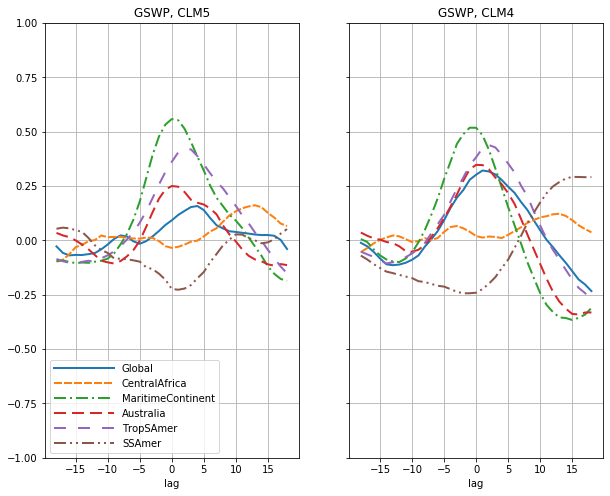

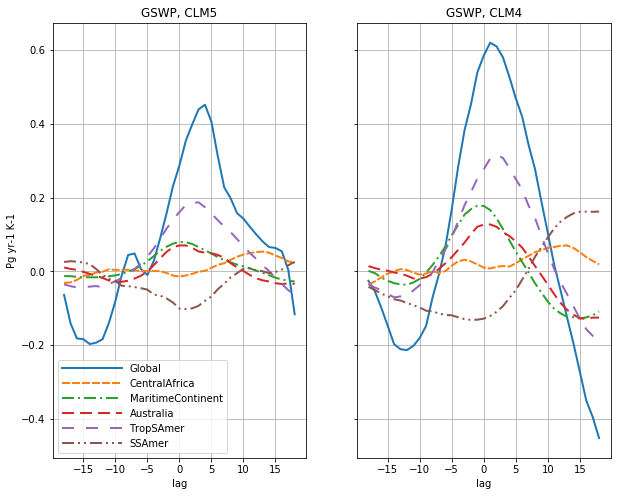

In [9]:
corr_anal(('nino34sst', 'NEE'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=GPP, experiment=GSWP-CLM5
Global: -0.599
CentralAfrica: 0.053
MaritimeContinent: -0.078
Australia: -0.269
TropSAmer: -0.303
SSAmer: 0.109
varname_x=nino34sst, region_x=nino34, varname_y=GPP, experiment=GSWP-CLM4
Global: -0.697, 0.098
CentralAfrica: 0.055, -0.002
MaritimeContinent: -0.355, 0.276
Australia: -0.178, -0.091
TropSAmer: -0.359, 0.055
SSAmer: 0.309, -0.200


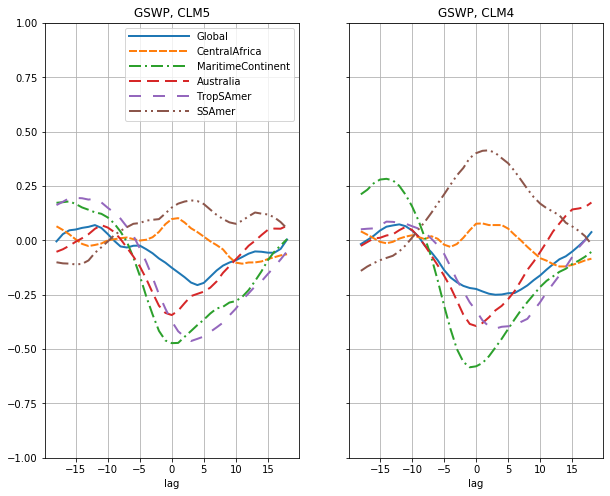

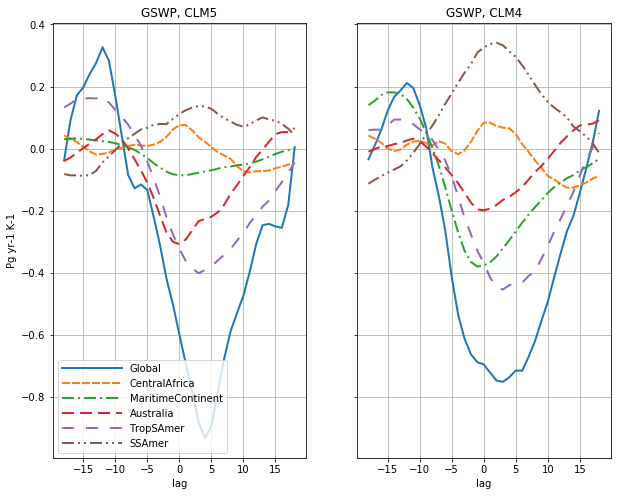

In [10]:
corr_anal(('nino34sst', 'GPP'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=NPP, experiment=GSWP-CLM5
Global: -0.403
CentralAfrica: 0.004
MaritimeContinent: -0.083
Australia: -0.131
TropSAmer: -0.218
SSAmer: 0.128
varname_x=nino34sst, region_x=nino34, varname_y=NPP, experiment=GSWP-CLM4
Global: -0.563, 0.160
CentralAfrica: -0.016, 0.020
MaritimeContinent: -0.148, 0.065
Australia: -0.093, -0.038
TropSAmer: -0.288, 0.070
SSAmer: 0.093, 0.035


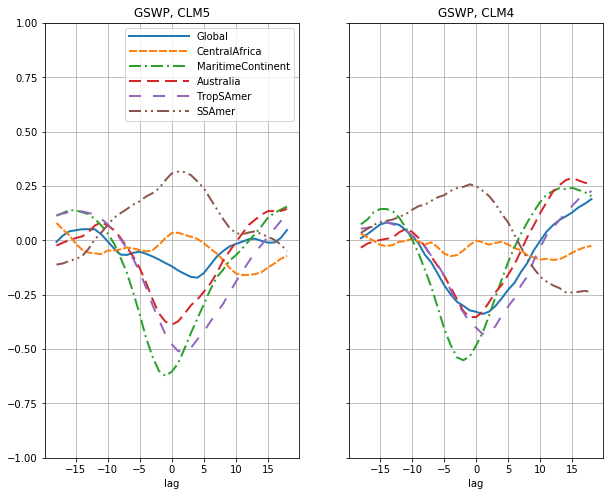

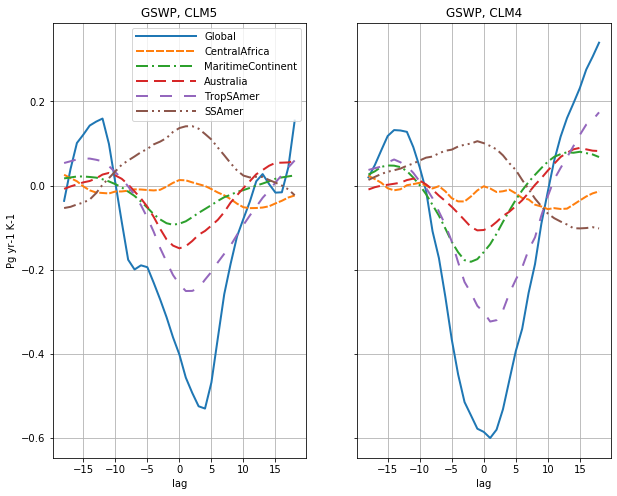

In [11]:
corr_anal(('nino34sst', 'NPP'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=AR, experiment=GSWP-CLM5
Global: -0.196
CentralAfrica: 0.049
MaritimeContinent: 0.005
Australia: -0.138
TropSAmer: -0.086
SSAmer: -0.020
varname_x=nino34sst, region_x=nino34, varname_y=AR, experiment=GSWP-CLM4
Global: -0.134, -0.062
CentralAfrica: 0.071, -0.022
MaritimeContinent: -0.207, 0.212
Australia: -0.085, -0.053
TropSAmer: -0.071, -0.015
SSAmer: 0.215, -0.235


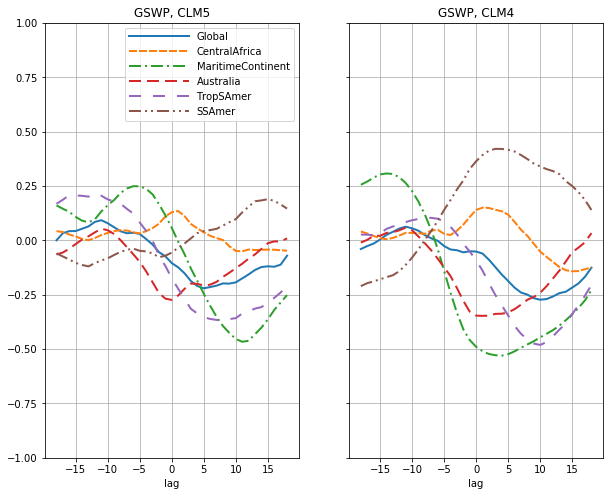

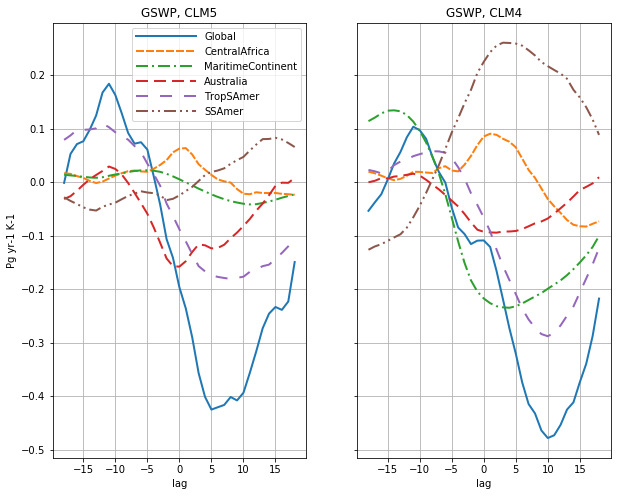

In [12]:
corr_anal(('nino34sst', 'AR'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=TOTVEGC, experiment=GSWP-CLM5
Global: -0.010
CentralAfrica: 0.031
MaritimeContinent: -0.022
Australia: -0.026
TropSAmer: -0.007
SSAmer: 0.046
varname_x=nino34sst, region_x=nino34, varname_y=TOTVEGC, experiment=GSWP-CLM4
Global: -0.092, 0.082
CentralAfrica: 0.053, -0.022
MaritimeContinent: -0.138, 0.115
Australia: -0.071, 0.045
TropSAmer: -0.045, 0.038
SSAmer: 0.186, -0.140


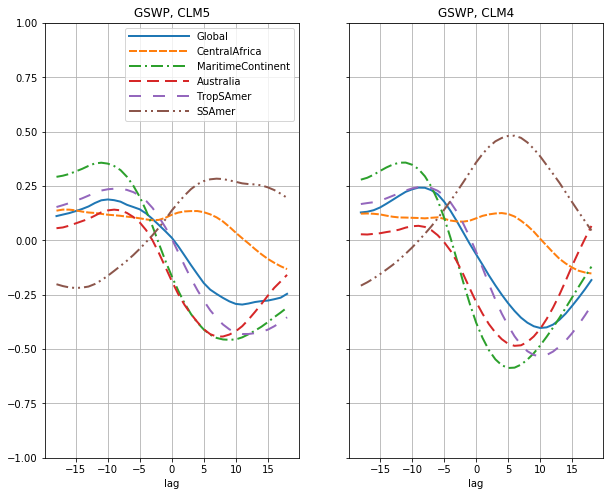

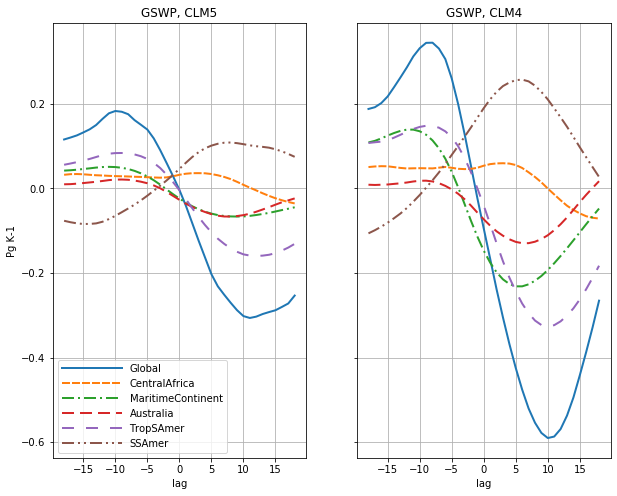

In [13]:
corr_anal(('nino34sst', 'TOTVEGC'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=HR, experiment=GSWP-CLM5
Global: -0.144
CentralAfrica: 0.014
MaritimeContinent: -0.045
Australia: -0.089
TropSAmer: -0.083
SSAmer: 0.085
varname_x=nino34sst, region_x=nino34, varname_y=HR, experiment=GSWP-CLM4
Global: -0.145, 0.001
CentralAfrica: 0.002, 0.012
MaritimeContinent: -0.048, 0.002
Australia: 0.007, -0.096
TropSAmer: -0.082, -0.001
SSAmer: -0.013, 0.098


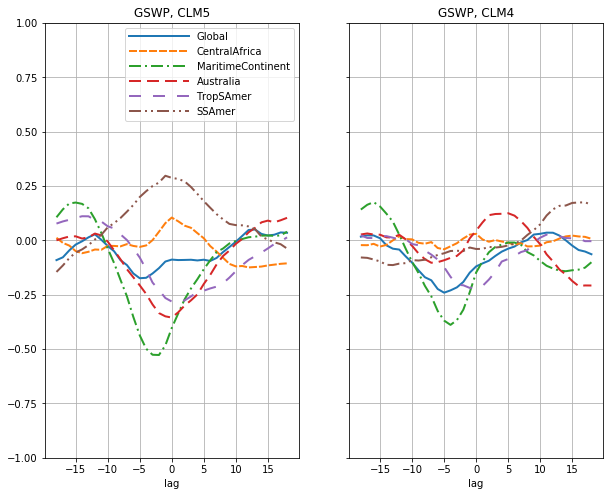

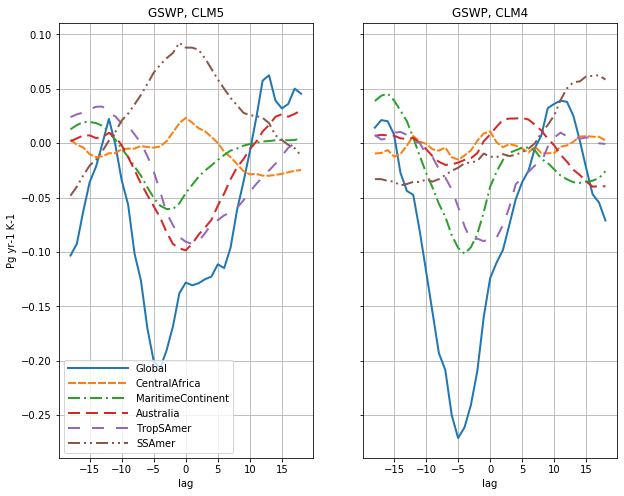

In [14]:
corr_anal(('nino34sst', 'HR'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=COL_FIRE_CLOSS, experiment=GSWP-CLM5
Global: 0.021
CentralAfrica: -0.017
MaritimeContinent: 0.033
Australia: 0.017
TropSAmer: 0.017
SSAmer: -0.045
varname_x=nino34sst, region_x=nino34, varname_y=COL_FIRE_CLOSS, experiment=GSWP-CLM4
Global: 0.114, -0.093
CentralAfrica: -0.001, -0.015
MaritimeContinent: 0.055, -0.022
Australia: 0.012, 0.005
TropSAmer: 0.058, -0.042
SSAmer: -0.015, -0.030


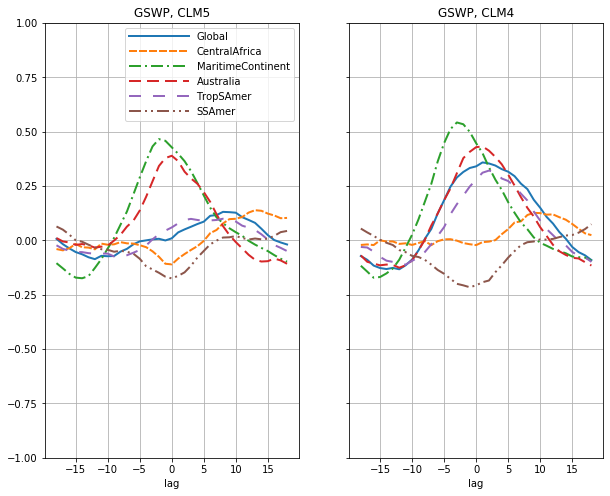

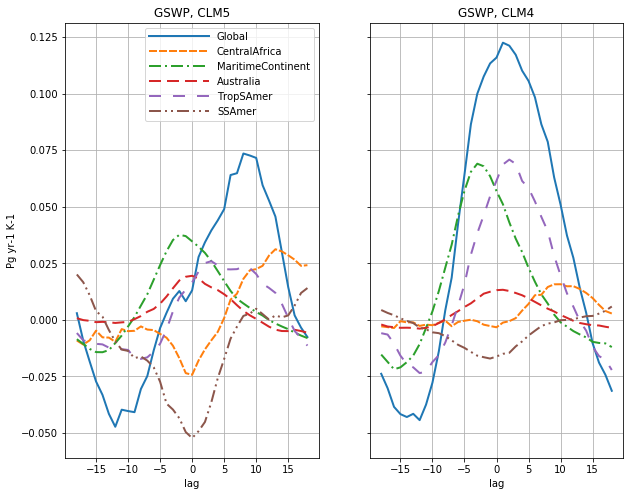

In [15]:
corr_anal(('nino34sst', 'COL_FIRE_CLOSS'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=TOTSOMC, experiment=GSWP-CLM5
Global: 0.016
CentralAfrica: 0.001
MaritimeContinent: 0.003
Australia: -0.000
TropSAmer: 0.005
SSAmer: -0.002
varname_x=nino34sst, region_x=nino34, varname_y=TOTSOMC, experiment=GSWP-CLM4
Global: 0.036, -0.020
CentralAfrica: -0.002, 0.003
MaritimeContinent: 0.018, -0.015
Australia: 0.013, -0.013
TropSAmer: 0.011, -0.005
SSAmer: -0.030, 0.029


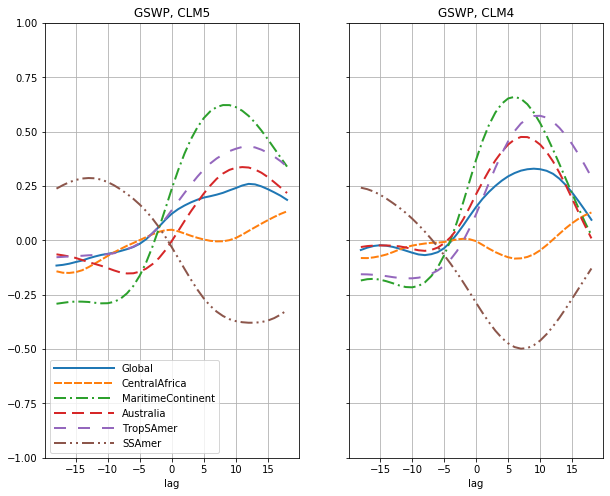

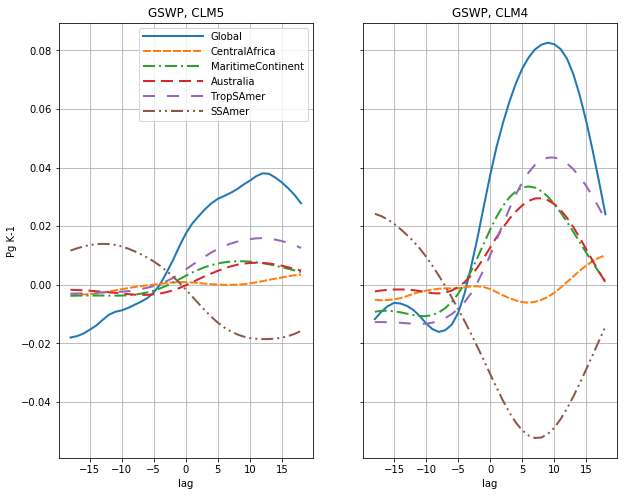

In [16]:
corr_anal(('nino34sst', 'TOTSOMC'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=TSA, experiment=GSWP-CLM5
Global: 0.055
CentralAfrica: 0.127
MaritimeContinent: 0.072
Australia: 0.131
TropSAmer: 0.200
SSAmer: 0.133
varname_x=nino34sst, region_x=nino34, varname_y=TSA, experiment=GSWP-CLM4
Global: 0.057, -0.002
CentralAfrica: 0.132, -0.005
MaritimeContinent: 0.068, 0.004
Australia: 0.138, -0.007
TropSAmer: 0.195, 0.005
SSAmer: 0.128, 0.005


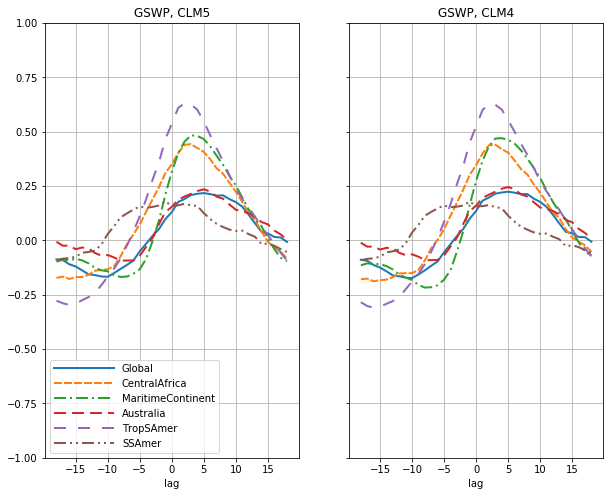

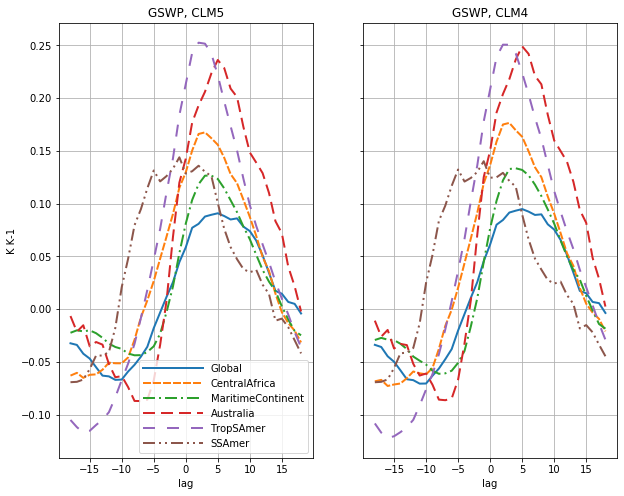

In [17]:
corr_anal(('nino34sst', 'TSA'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=TSOI_10CM, experiment=GSWP-CLM5
Global: 0.054
CentralAfrica: 0.122
MaritimeContinent: 0.099
Australia: 0.152
TropSAmer: 0.186
SSAmer: 0.107
varname_x=nino34sst, region_x=nino34, varname_y=TSOI_10CM, experiment=GSWP-CLM4
Global: 0.048, 0.006
CentralAfrica: 0.104, 0.018
MaritimeContinent: 0.123, -0.023
Australia: 0.194, -0.042
TropSAmer: 0.177, 0.009
SSAmer: 0.073, 0.033


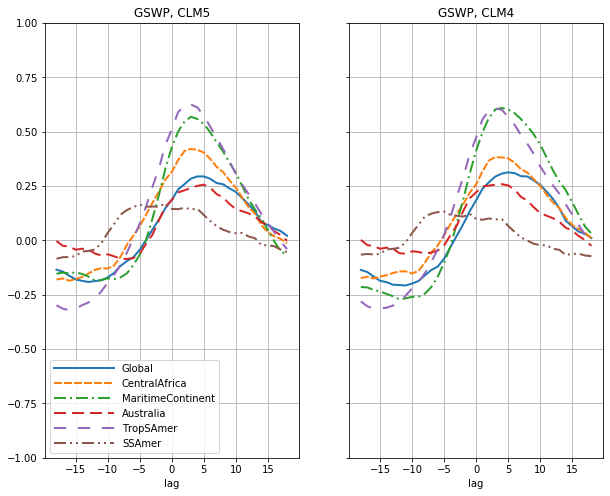

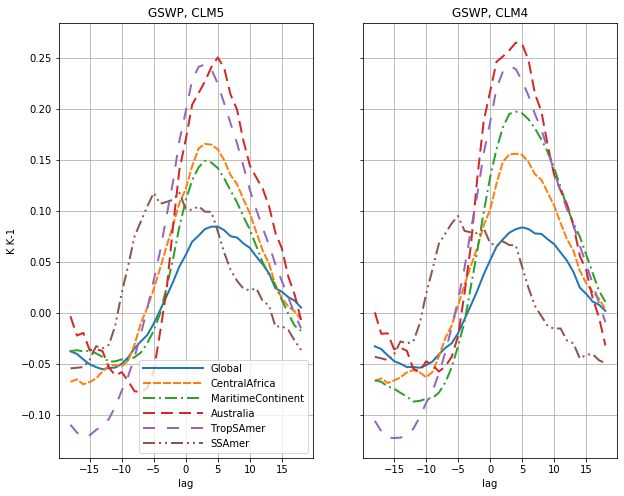

In [18]:
corr_anal(('nino34sst', 'TSOI_10CM'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=RAIN, experiment=GSWP-CLM5
Global: -0.035
CentralAfrica: 0.009
MaritimeContinent: -0.549
Australia: -0.179
TropSAmer: -0.244
SSAmer: 0.147
varname_x=nino34sst, region_x=nino34, varname_y=RAIN, experiment=GSWP-CLM4
Global: -0.035, 0.000
CentralAfrica: 0.009, 0.000
MaritimeContinent: -0.549, 0.000
Australia: -0.179, 0.000
TropSAmer: -0.244, -0.000
SSAmer: 0.147, -0.000


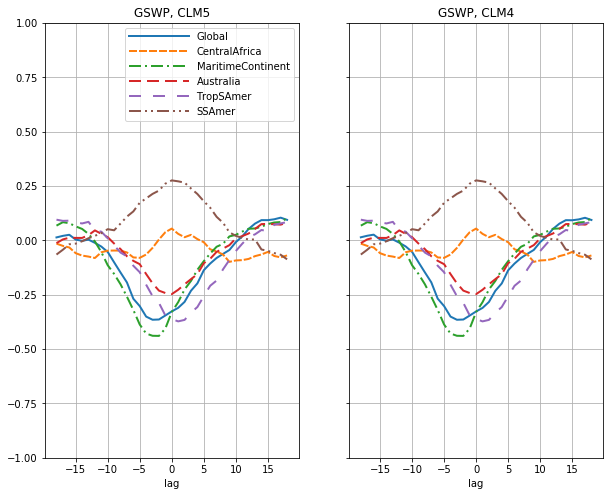

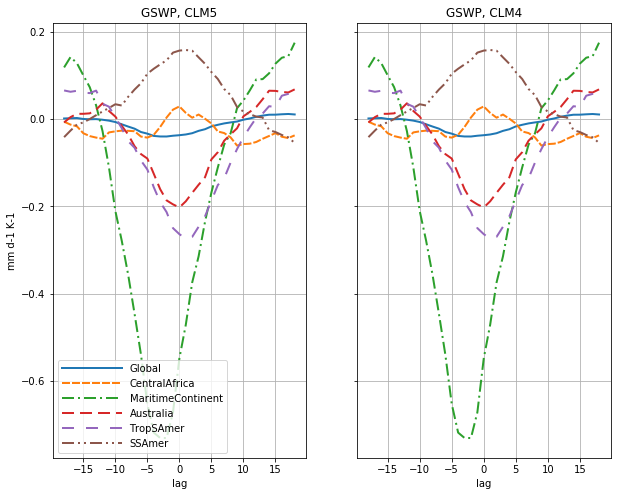

In [19]:
corr_anal(('nino34sst', 'RAIN'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=SOILLIQ_10CM, experiment=GSWP-CLM5
Global: -0.024
CentralAfrica: 0.015
MaritimeContinent: -0.430
Australia: -0.253
TropSAmer: -0.219
SSAmer: 0.189
varname_x=nino34sst, region_x=nino34, varname_y=SOILLIQ_10CM, experiment=GSWP-CLM4
Global: -0.026, 0.002
CentralAfrica: 0.016, -0.002
MaritimeContinent: -0.436, 0.006
Australia: -0.174, -0.079
TropSAmer: -0.184, -0.035
SSAmer: 0.126, 0.063


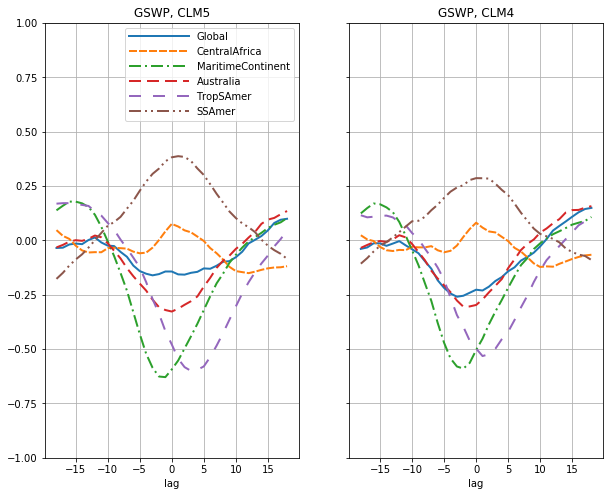

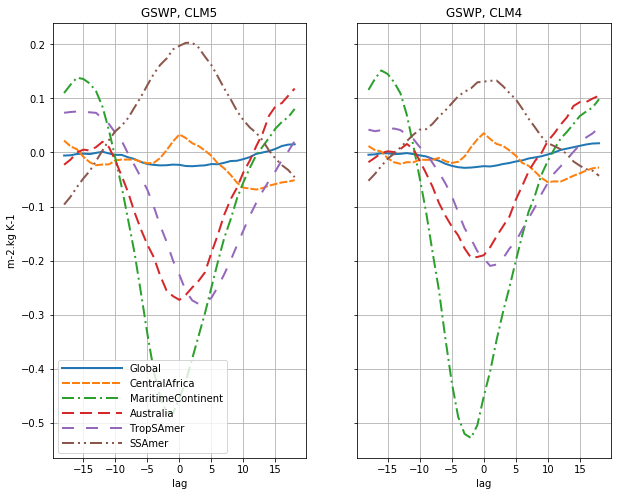

In [20]:
corr_anal(('nino34sst', 'SOILLIQ_10CM'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=obs,component_y=lnd
varname_x=nino34sst, region_x=nino34, varname_y=SOILLIQ_TOT, experiment=GSWP-CLM5
Global: -2.972
CentralAfrica: -1.511
MaritimeContinent: -38.305
Australia: -12.425
TropSAmer: -16.865
SSAmer: 11.951
varname_x=nino34sst, region_x=nino34, varname_y=SOILLIQ_TOT, experiment=GSWP-CLM4
Global: -2.262, -0.710
CentralAfrica: -0.493, -1.018
MaritimeContinent: -31.356, -6.949
Australia: -7.815, -4.610
TropSAmer: -11.816, -5.048
SSAmer: 6.032, 5.919


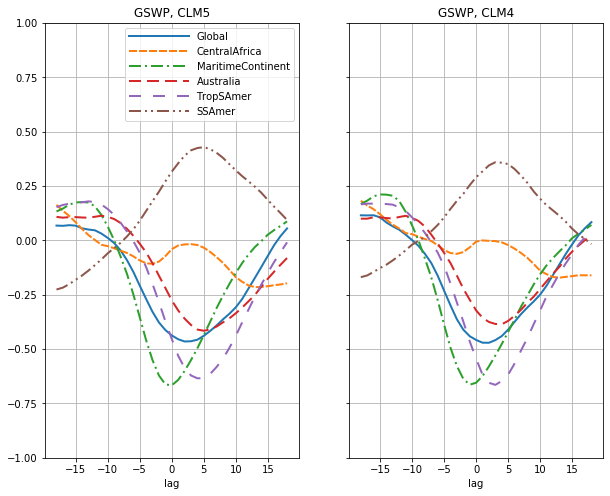

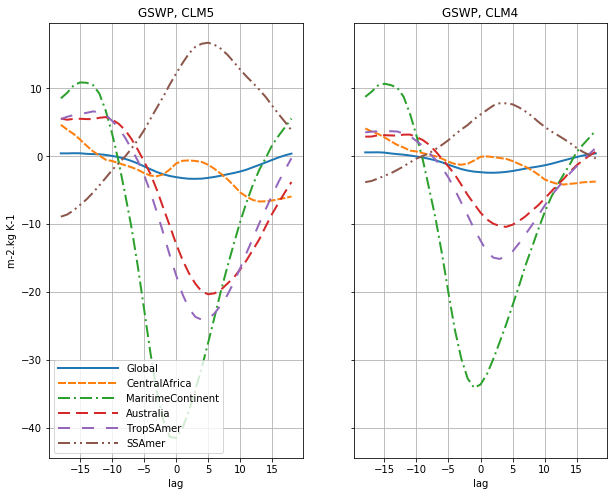

In [21]:
corr_anal(('nino34sst', 'SOILLIQ_TOT'), ['GSWP-CLM5', 'GSWP-CLM4'])

component_x=lnd,component_y=lnd
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=GPP, experiment=GSWP-CLM5
CentralAfrica: 0.012
MaritimeContinent: 0.002
Australia: 0.008
TropSAmer: 0.014
SSAmer: 0.008
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=GPP, experiment=GSWP-CLM4
CentralAfrica: 0.022, -0.010
MaritimeContinent: 0.009, -0.008
Australia: 0.009, -0.001
TropSAmer: 0.028, -0.014
SSAmer: 0.019, -0.011


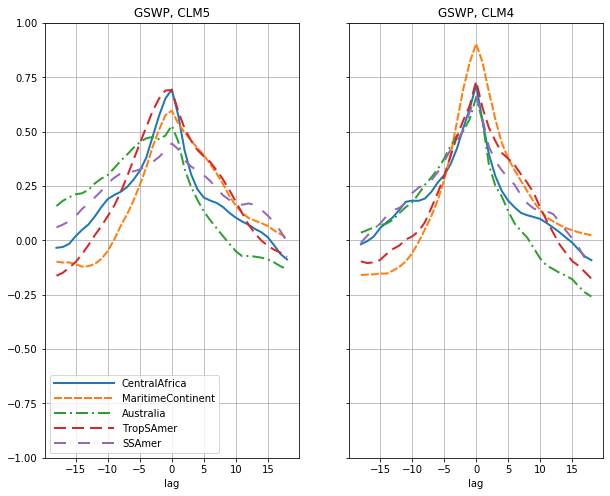

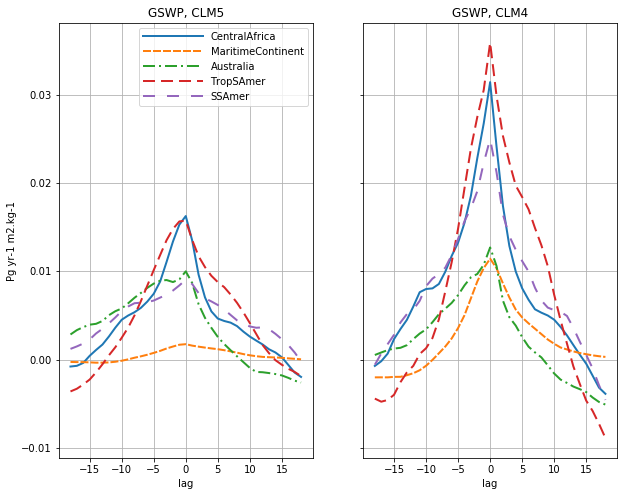

In [22]:
corr_anal(('SOILLIQ_TOT', 'GPP'), ['GSWP-CLM5', 'GSWP-CLM4'], component_pair=('lnd', 'lnd'), region_x='region_y',
          region_y_list=['CentralAfrica', 'MaritimeContinent', 'Australia','TropSAmer', 'SSAmer'])

component_x=lnd,component_y=lnd
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=HR, experiment=GSWP-CLM5
CentralAfrica: 0.004
MaritimeContinent: 0.001
Australia: 0.002
TropSAmer: 0.004
SSAmer: 0.004
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=HR, experiment=GSWP-CLM4
CentralAfrica: 0.002, 0.002
MaritimeContinent: 0.002, -0.001
Australia: -0.000, 0.002
TropSAmer: 0.004, -0.001
SSAmer: 0.001, 0.003


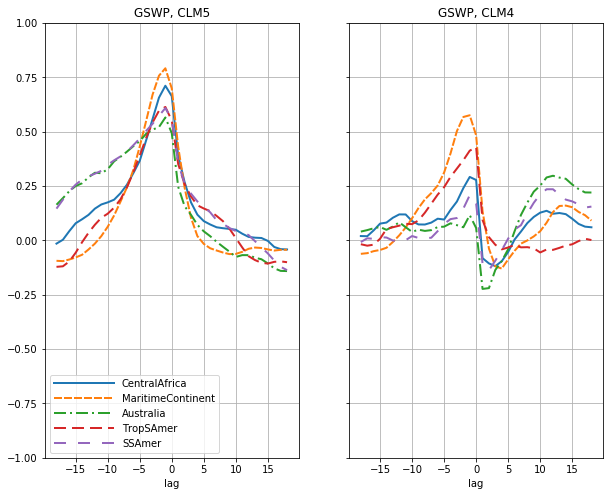

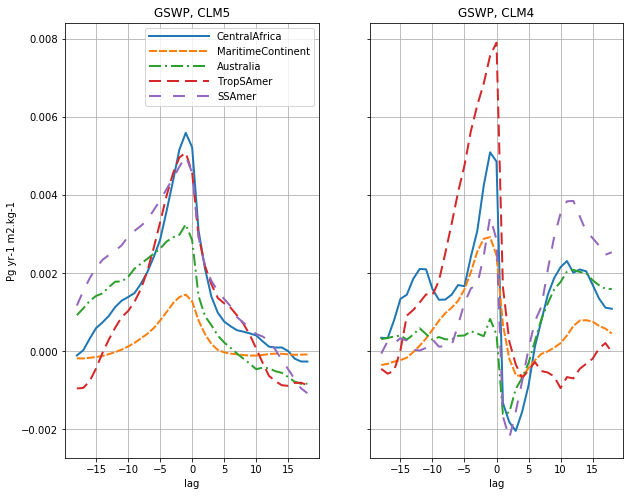

In [23]:
corr_anal(('SOILLIQ_TOT', 'HR'), ['GSWP-CLM5', 'GSWP-CLM4'], component_pair=('lnd', 'lnd'), region_x='region_y',
          region_y_list=['CentralAfrica', 'MaritimeContinent', 'Australia','TropSAmer', 'SSAmer'])

component_x=lnd,component_y=lnd
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=SOILLIQ_TOT, experiment=GSWP-CLM5
CentralAfrica: 0.847
MaritimeContinent: 0.835
Australia: 0.906
TropSAmer: 0.882
SSAmer: 0.916
varname_x=SOILLIQ_TOT, region_x=region_y, varname_y=SOILLIQ_TOT, experiment=GSWP-CLM4
CentralAfrica: 0.802, 0.045
MaritimeContinent: 0.807, 0.027
Australia: 0.832, 0.074
TropSAmer: 0.799, 0.082
SSAmer: 0.821, 0.095


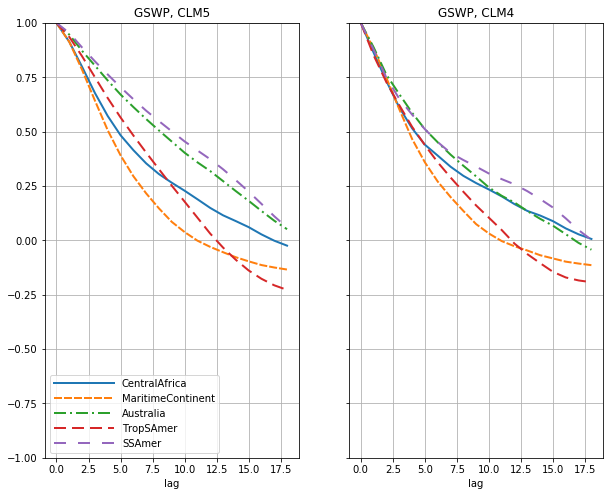

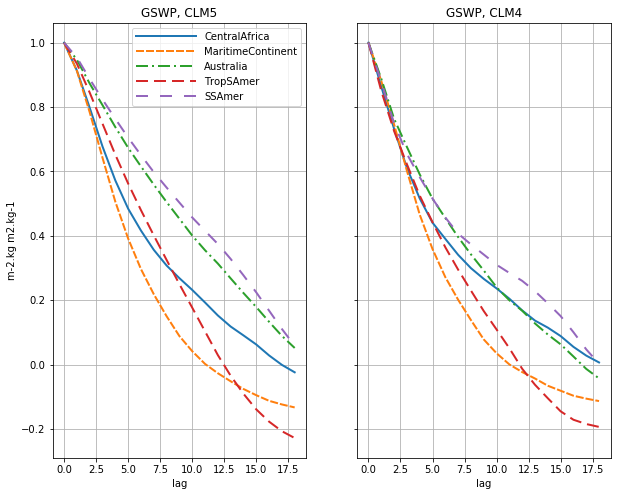

In [24]:
corr_anal(('SOILLIQ_TOT', 'SOILLIQ_TOT'), ['GSWP-CLM5', 'GSWP-CLM4'], component_pair=('lnd', 'lnd'), region_x='region_y',
          region_y_list=['CentralAfrica', 'MaritimeContinent', 'Australia','TropSAmer', 'SSAmer'],
          lag_values = range(0,18+1))